In [1]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

# from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
import os
import torch
import numpy as np

KeyboardInterrupt: 

C:\Users\vohi0\AppData\Local\Temp\ipykernel_12372\2194723663.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2318.)
  img = item[0].T


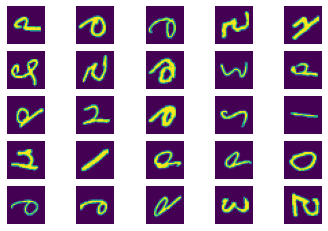

In [ ]:
def load_real_samples():
	# load dataset
	train_x = []
	train_y = []
	for client in range(10):
		for item in torch.load('../data/MNIST.pth')[client]:
			img = item[0].T
			train_x.append(np.array(img))
			train_x = [x for x in train_x]
			train_y.append(np.array(item[1]))
	return [np.array(train_x), np.array(train_y)]

(trainX, trainy) = load_real_samples()

# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])
pyplot.show()


In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 384 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((7, 7, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'results/ACGAN/generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'results/ACGAN/model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train the generator and discriminator
# def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=10):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		# if (i+1) % (bat_per_epo * 10) == 0:
		if (i+1) % 1000 == 0:
			summarize_performance(i, g_model, latent_dim)
			break

# make folder for results
os.makedirs('results/ACGAN', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

d:\Projects\TRUSTCOM2022\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 173ms/step
>1, dr[0.448,3.542], df[1.974,2.295], g[0.854,3.434]
1/1 [==============================] - 0s 19ms/step
>2, dr[0.549,4.052], df[1.217,4.509], g[0.633,3.640]
1/1 [==============================] - 0s 17ms/step
>3, dr[0.953,2.306], df[0.994,3.078], g[0.958,3.326]
1/1 [==============================] - 0s 18ms/step
>4, dr[0.609,3.642], df[0.798,2.935], g[0.805,3.463]
1/1 [==============================] - 0s 19ms/step
>5, dr[0.729,3.852], df[0.375,4.120], g[0.928,3.983]
1/1 [==============================] - 0s 17ms/step
>6, dr[0.441,4.216], df[0.932,3.999], g[0.784,3.673]
1/1 [==============================] - 0s 16ms/step
>7, dr[0.418,3.601], df[0.769,3.813], g[1.192,3.223]
1/1 [==============================] - 0s 17ms/step
>8, dr[0.612,3.302], df[1.006,3.910], g[1.130,2.709]
1/1 [==============================] - 0s 18ms/step
>9, dr[0.655,4.167], df[0.425,3.501], g[0.955,3.375]
1/1 [==============================] - 0s 18ms/step
>1

In [ ]:
print(discriminator.get_weights()[20].shape)
print(discriminator.get_weights()[21].shape)
print(discriminator.get_weights()[22].shape)
print(discriminator.get_weights()[23].shape)

(12544, 1)
(1,)
(12544, 10)
(10,)


In [5]:
{w.name: (w.dtype, w.shape) for w in discriminator.weights}

{'conv2d/kernel:0': (tf.float32, TensorShape([3, 3, 1, 32])),
 'conv2d/bias:0': (tf.float32, TensorShape([32])),
 'conv2d_1/kernel:0': (tf.float32, TensorShape([3, 3, 32, 64])),
 'conv2d_1/bias:0': (tf.float32, TensorShape([64])),
 'batch_normalization/gamma:0': (tf.float32, TensorShape([64])),
 'batch_normalization/beta:0': (tf.float32, TensorShape([64])),
 'batch_normalization/moving_mean:0': (tf.float32, TensorShape([64])),
 'batch_normalization/moving_variance:0': (tf.float32, TensorShape([64])),
 'conv2d_2/kernel:0': (tf.float32, TensorShape([3, 3, 64, 128])),
 'conv2d_2/bias:0': (tf.float32, TensorShape([128])),
 'batch_normalization_1/gamma:0': (tf.float32, TensorShape([128])),
 'batch_normalization_1/beta:0': (tf.float32, TensorShape([128])),
 'batch_normalization_1/moving_mean:0': (tf.float32, TensorShape([128])),
 'batch_normalization_1/moving_variance:0': (tf.float32, TensorShape([128])),
 'conv2d_3/kernel:0': (tf.float32, TensorShape([3, 3, 128, 256])),
 'conv2d_3/bias:0': 

In [6]:
#################################
##### Neural Network model #####
#################################
import torch.nn as nn

class VGG(nn.Module):
    def __init__(self, channels=1, hideen=1, num_classes=10):
        super(VGG, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(0.5),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(12544, num_classes)
            # nn.Linear(hideen, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
torch_model = torch.load("../pretrained/test_torch.pt")
torch_weights = torch_model.body.state_dict()
# Reshape weights for Keras model
keras_weights = [w.cpu().numpy() for w in torch_weights.values()]

print("Convolution Layers")
for i in [0, 2, 9, 16]:
    print(keras_weights[i].shape)
    # conv2d layer: Torch (out,in,h,w) Keras (h,w,in,out)
    keras_weights[i] = np.moveaxis(keras_weights[i], [0,1], [-1,-2])
    
keras_weights = [v for v in keras_weights if v.shape != ()]

keras_weights.append(discriminator.get_weights()[20])
keras_weights.append(discriminator.get_weights()[21])
keras_weights.append(torch_model.fc[0].weight.cpu().detach().numpy().T)
keras_weights.append(discriminator.get_weights()[23])

# 'dense/kernel:0': (tf.float32, TensorShape([12544, 1])),
#  'dense/bias:0': (tf.float32, TensorShape([1])),
#  'dense_1/kernel:0': (tf.float32, TensorShape([12544, 10])),
#  'dense_1/bias:0': (tf.float32, TensorShape([10]))}

print("Dense Layers")
print(keras_weights[len(keras_weights)-4].shape)
print(keras_weights[len(keras_weights)-2].shape)

Convolution Layers
(32, 1, 3, 3)
(64, 32, 3, 3)
(128, 64, 3, 3)
(256, 128, 3, 3)
Dense Layers
(12544, 1)
(12544, 10)


In [8]:
# discriminator.set_weights(keras_weights)

In [9]:
# gan_model = define_gan(generator, discriminator)
# # load image data
# dataset = load_real_samples()
# # train model
# train(generator, discriminator, gan_model, dataset, latent_dim)

## Generate Images

In [10]:
from numpy import asarray
from keras.models import load_model
from math import sqrt

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = asarray([n_class for _ in range(n_samples)])
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# # load model
# model = load_model('model_93700.h5')
# latent_dim = 100
# n_examples = 100 # must be a square
# n_class = 7 # sneaker
# # generate images
# latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# # generate images
# X  = model.predict([latent_points, labels])
# # scale from [-1,1] to [0,1]
# X = (X + 1) / 2.0
# # plot the result
# save_plot(X, n_examples)